In [305]:
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.core.mutation import Mutation
from pymoo.core.crossover import Crossover
from pymoo.core.sampling import Sampling
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize

In [306]:
class CustomHybridMutation(Mutation):
    """Custom mutation for permutation (sequence) and integer (machine choices)."""
    def __init__(self, prob=0.1):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        n_individuals, n_var = X.shape
        seq_length = problem.seq_length
        n_stages = problem.n_stages
        Y = X.copy()

        for i in range(n_individuals):
            # Permutation mutation
            if np.random.random() < self.prob:
                idx1, idx2 = np.random.choice(seq_length, size=2, replace=False)
                Y[i, :seq_length][[idx1, idx2]] = Y[i, :seq_length][[idx2, idx1]]
            # Machine choice mutation
            machine_choices = Y[i, seq_length:].reshape(seq_length, n_stages)
            for j in range(seq_length):
                for s in range(n_stages):
                    if np.random.random() < self.prob:
                        machine_choices[j, s] = np.random.randint(0, problem.machines_per_stage[s])
            Y[i, seq_length:] = machine_choices.flatten()

        return Y.astype(int)

class CustomHybridCrossover(Crossover):
    """Custom crossover for permutation and integer parts."""
    def __init__(self, prob=0.5):
        super().__init__(2, 2)
        self.prob = prob
        self.order_cx = OrderCrossover()
        self.uniform_cx = UniformCrossover(prob=prob)

    def _do(self, problem, X, **kwargs):
        n_parents, n_matings, n_var = X.shape
        seq_length = problem.seq_length
        Y = np.zeros_like(X)

        for k in range(n_matings):
            a, b = X[:, k, :]
            perm_a, perm_b = self.order_cx._do(problem, np.array([[a[:seq_length]], [b[:seq_length]]]))[:, 0, :]
            machine_a, machine_b = self.uniform_cx._do(problem, np.array([[a[seq_length:]], [b[seq_length:]]]))[:, 0, :]
            Y[0, k, :seq_length] = perm_a
            Y[1, k, :seq_length] = perm_b
            Y[0, k, seq_length:] = machine_a
            Y[1, k, seq_length:] = machine_b

        return Y.astype(int)

class CustomHybridSampling(Sampling):
    """Custom sampling for permutation and integer parts."""
    def _do(self, problem, n_samples, **kwargs):
        seq_length = problem.seq_length
        n_stages = problem.n_stages
        X = np.zeros((n_samples, problem.n_var), dtype=int)

        for i in range(n_samples):
            X[i, :seq_length] = np.random.permutation(seq_length)
            machine_choices = np.zeros((seq_length, n_stages), dtype=int)
            for j in range(seq_length):
                for s in range(n_stages):
                    machine_choices[j, s] = np.random.randint(0, problem.machines_per_stage[s])
            X[i, seq_length:] = machine_choices.flatten()

        return X

In [307]:
class BakeryHybridSchedulingProblem(Problem):
    def __init__(self, user_sequence_idx, recipe_id_to_index, machines_per_stage, processing_times, changeover_times, batch_sizes, tact_times, recipe_ids, recipe_required_stages, debug=False):
        self.seq_length = len(user_sequence_idx)
        self.user_sequence_idx = np.array(user_sequence_idx)
        self.recipe_id_to_index = recipe_id_to_index
        self.n_stages = len(machines_per_stage)
        self.machines_per_stage = machines_per_stage
        self.max_makespan = 0
        self.max_machines = max(machines_per_stage)
        self.debug = debug
        self.recipe_ids = recipe_ids
        self.recipe_index_to_required_stages = {self.recipe_id_to_index[rid]: stages for rid, stages in recipe_required_stages.items()}
        n_var = self.seq_length + (self.seq_length * self.n_stages)
        super().__init__(
            n_var=n_var,
            n_obj=1,
            n_constr=0,
            xl=[0] * n_var,
            xu=[self.seq_length - 1]*self.seq_length + [m - 1 for m in machines_per_stage for _ in range(self.seq_length)],
            type_var=int)
        self.processing_times = processing_times
        self.changeover_times = changeover_times
        self.batch_sizes = batch_sizes
        self.tact_times = tact_times

    def _evaluate(self, X, out, *args, **kwargs):
        makespans = np.array([self.calculate_makespan(x, store_best=False) for x in X])
        out["F"] = makespans

    def calculate_makespan(self, x, store_best=True):
        # Unpack Solution
        perm = x[:self.seq_length]
        machine_choices = x[self.seq_length:].reshape(self.seq_length, self.n_stages)
        job_recipe_indices = self.user_sequence_idx[perm]
        permuted_batch_sizes = np.array(self.batch_sizes)[perm]

        if self.debug and store_best:
            print(f"Calculating makespan for sequence: {job_recipe_indices}\nWith machine choices:\n{machine_choices}")
            print("====" * 20)

        # Initialize Tracking Arrays
        start_times = np.full((self.seq_length, self.n_stages), -1.0)
        end_times = np.full((self.seq_length, self.n_stages), -1.0)
        changeover_times_array = np.full((self.seq_length, self.n_stages), -1.0)
        machine_free_times = np.zeros((self.n_stages, self.max_machines))
        changeover_start_times = np.full((self.seq_length, self.n_stages), -1.0)
        changeover_end_times = np.full((self.seq_length, self.n_stages), -1.0)

        for job_idx in range(self.seq_length):
            job_recipe_index = job_recipe_indices[job_idx]
            required_stages = self.recipe_index_to_required_stages[job_recipe_index]
            batch_size = permuted_batch_sizes[job_idx]
            batch_delay = (batch_size - 1) * self.tact_times[job_recipe_index]

            if not required_stages:
                continue

            for s_position, s in enumerate(required_stages):
                m = machine_choices[job_idx, s]

                # Find the last job scheduled on this machine at this stage
                last_job_on_machine = None
                for prev_job_idx in range(job_idx - 1, -1, -1):
                    prev_recipe_index = job_recipe_indices[prev_job_idx]
                    if s in self.recipe_index_to_required_stages[prev_recipe_index] and machine_choices[prev_job_idx, s] == m:
                        last_job_on_machine = prev_job_idx
                        break

                if last_job_on_machine is None:
                    changeover = 0
                    changeover_start = 0
                    changeover_end = 0
                    machine_ready_time = max(0, machine_free_times[s, m])
                else:
                    prev_recipe_index = job_recipe_indices[last_job_on_machine]
                    if prev_recipe_index != job_recipe_index:
                        changeover = self.changeover_times[s, m, prev_recipe_index, job_recipe_index]
                        changeover = changeover.item() if isinstance(changeover, np.ndarray) else changeover
                    else:
                        changeover = 0
                    changeover_start = end_times[last_job_on_machine, s]
                    changeover_end = changeover_start + changeover
                    machine_ready_time = changeover_end

                if s_position == 0:
                    # First required stage: can start when machine is ready
                    start_time = machine_ready_time
                else:
                    # For subsequent stages, check if no-wait condition is met
                    prev_s = required_stages[s_position - 1]
                    required_start = end_times[job_idx, prev_s] - batch_delay
                    start_time = max(required_start, machine_ready_time)

                    if start_time > required_start:
                        postpone_amount = start_time - required_start

                        if self.debug and store_best:
                            print(f"Postponing Recipe ID {self.recipe_ids[job_recipe_index]} at Stage {s} by {postpone_amount} time units to meet no-wait condition.")
                            prev_job_idx = next(
                                (prev_job_idx for prev_job_idx in range(job_idx - 1, -1, -1)
                                if s in self.recipe_index_to_required_stages[job_recipe_indices[prev_job_idx]] and machine_choices[prev_job_idx, s] == m),
                                None
                            )
                            if prev_job_idx is not None:
                                print(f"  Previous job on this machine: Recipe Index {job_recipe_indices[prev_job_idx]} (Recipe ID {self.recipe_ids[job_recipe_indices[prev_job_idx]]}), ends at {end_times[prev_job_idx, s]}")
                            else:
                                print("  No previous job on this machine at this stage.")
                            print(f"  end_times[last_job_on_machine, {s}]", end_times[last_job_on_machine, s] if last_job_on_machine is not None else None)
                            print(f"  machine_free_times[{s}, {m}]: {machine_free_times[s, m]}")
                            print("  changeover_start:", changeover_start)
                            print("  changeover:", changeover)
                            print("  changeover_end:", changeover_end)
                            print(f"  machine_ready_time: {start_time}")
                            print(f"  required_start: {required_start}")
                            print(f"  postpone_amount: {postpone_amount}")

                        # Postpone all previous required stages for this job
                        for ss_pos in range(s_position):
                            ss = required_stages[ss_pos]
                            start_times[job_idx, ss] += postpone_amount
                            end_times[job_idx, ss] += postpone_amount
                            m_ss = machine_choices[job_idx, ss]
                            machine_free_times[ss, m_ss] = end_times[job_idx, ss]
                        # Recompute start_time after postponement
                        start_time = max(end_times[job_idx, prev_s] - batch_delay, machine_ready_time)

                # Record changeover and processing times
                changeover_times_array[job_idx, s] = changeover
                changeover_start_times[job_idx, s] = changeover_start
                changeover_end_times[job_idx, s] = changeover_end

                processing_duration = self.processing_times[s, m, job_recipe_index]
                end_time = start_time + processing_duration + batch_delay
                
                start_times[job_idx, s] = start_time
                end_times[job_idx, s] = end_time
                machine_free_times[s, m] = end_time

            if self.debug and store_best:
                print('--'*10)
                print(f"Job {job_idx}, Recipe Index {job_recipe_index} (Recipe ID {self.recipe_ids[job_recipe_index]}) scheduled:")
                # Print schedule for this job
                for s in required_stages:
                    m = machine_choices[job_idx, s]
                    changeover = changeover_times_array[job_idx, s]
                    changeover_start = changeover_start_times[job_idx, s]
                    changeover_end = changeover_end_times[job_idx, s]
                    start_time = start_times[job_idx, s]
                    end_time = end_times[job_idx, s]
                    duration = end_time - start_time
                    print(f"  Stage {s}, Machine {m}: Start={start_time}, duration={duration}, End={end_time}, "
                          f"Changeover={changeover} (Start={changeover_start}, End={changeover_end})")
                print('--'*10)
                # Print out difference of start time at this stage compared to the previous stage
                for idx, s in enumerate(required_stages):
                    if idx > 0:
                        prev_s = required_stages[idx - 1]
                        prev_start_time = start_times[job_idx, prev_s]
                        time_diff = start_time - prev_start_time
                        print(f"Start Time difference Current Stage {s} vs. Previous Stage {prev_s}: {time_diff}")
                print('--'*10)
                print('\n')

        # Compute makespan
        makespan = 0
        for job_idx in range(self.seq_length):
            job_recipe_index = job_recipe_indices[job_idx]
            required_stages = self.recipe_index_to_required_stages[job_recipe_index]
            if required_stages:
                last_stage = required_stages[-1]
                makespan = max(makespan, end_times[job_idx, last_stage])

        if store_best:
            self.best_start_times = start_times
            self.best_end_times = end_times
            self.best_machine_choices = machine_choices
            self.best_sequence_ids = [self.recipe_ids[idx] for idx in job_recipe_indices]
            self.best_changeover_times = changeover_times_array
            self.best_changeover_start_times = changeover_start_times
            self.best_changeover_end_times = changeover_end_times
            self.max_makespan = makespan

            # Debug output for best solution
            if self.debug:
                print("Best Sequence IDs:", self.best_sequence_ids)
                print("Best Start Times:\n", self.best_start_times)
                print("Best End Times:\n", self.best_end_times)
                print("Best Machine Choices:\n", self.best_machine_choices)
                print("Machine free times:\n", machine_free_times)
                print("Best Changeover Times:\n", self.best_changeover_times)
                print("Best Changeover Start Times:\n", self.best_changeover_start_times)
                print("Best Changeover End Times:\n", self.best_changeover_end_times)
                print("Max Makespan:", self.max_makespan)

        return makespan



    def plot_gantt_chart(self):
        fig, ax = plt.subplots(figsize=(14, 7))

        stage_labels = []
        stage_machine_indices = []
        for s in range(self.n_stages):
            for m in range(self.machines_per_stage[s]):
                stage_labels.append(f"Stage {s} (Machine {m})")
                stage_machine_indices.append((s, m))
        stage_labels = stage_labels[::-1]
        stage_machine_indices = stage_machine_indices[::-1]
        y_positions = np.arange(len(stage_labels))

        unique_recipes = list(dict.fromkeys(self.best_sequence_ids))
        colors = {recipe_id: plt.cm.Set3(i % 12) for i, recipe_id in enumerate(unique_recipes)}

        recipe_counts = defaultdict(int)
        recipe_total_counts = Counter(self.best_sequence_ids)
        job_labels = []
        for rid in self.best_sequence_ids:
            recipe_counts[rid] += 1
            if recipe_total_counts[rid] > 1:
                job_labels.append(f"{rid} ({recipe_counts[rid]})")
            else:
                job_labels.append(f"{rid}")

        stage_start_idx = 0
        for s in range(self.n_stages):
            n_machines = self.machines_per_stage[s]
            stage_end_idx = stage_start_idx + n_machines
            idx_start = len(stage_labels) - stage_end_idx
            idx_end = len(stage_labels) - stage_start_idx
            if s % 2 == 0:
                ax.axhspan(idx_start - 0.5, idx_end - 0.5, facecolor="#ffffff", alpha=0.5, zorder=0)
            else:
                ax.axhspan(idx_start - 0.5, idx_end - 0.5, facecolor='#f5f5dc', alpha=0.5, zorder=0)
            stage_start_idx = stage_end_idx

        for i in range(self.seq_length):
            recipe_id = self.best_sequence_ids[i]
            recipe_index = self.recipe_id_to_index[recipe_id]
            required_stages = self.recipe_index_to_required_stages[recipe_index]
            label = job_labels[i]
            for s in required_stages:
                m = self.best_machine_choices[i, s]
                stage_idx = sum(self.machines_per_stage[:s]) + m
                y_idx = len(stage_labels) - 1 - stage_idx

                start_time = self.best_start_times[i, s]
                end_time = self.best_end_times[i, s]
                changeover = self.best_changeover_times[i, s]

                if changeover > 0:
                    changeover_start = start_time - changeover
                    ax.barh(y_positions[y_idx], changeover, left=changeover_start, height=0.5,
                            color='red', edgecolor='black', alpha=0.7,
                            label='Changeover' if (i == 0 and s == required_stages[0]) else "")

                process_duration = end_time - start_time
                ax.barh(y_positions[y_idx], process_duration, left=start_time, height=0.5,
                        color=colors[recipe_id], edgecolor='black')

                ax.text(start_time + process_duration / 2, y_positions[y_idx], label,
                        ha='center', va='center', color='white', fontweight='bold', fontsize=9)

        ax.grid(axis='x', which='major', linestyle='--', color='gray', alpha=0.5, zorder=0)
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
        ax.xaxis.set_ticks_position('both')
        ax.spines['bottom'].set_visible(False)
        ax.set_xlabel("Time")
        ax.set_yticks(y_positions)
        ax.set_yticklabels(stage_labels)
        ax.set_title("Batch Production Scheduling - Multi-stage Flowshop Optimization")
        ax.set_xlim(0, self.max_makespan + 10)
        ax.set_ylim(-0.5, len(stage_labels) - 0.5)
        handles = [plt.Rectangle((0,0),1,1, color=colors[rid], label=str(rid)) for rid in colors.keys()]
        ax.legend(handles=handles, loc='best', title="Recipe IDs")
        plt.tight_layout()
        plt.show()

    def export_schedule_for_js(self):
        schedule = []
        for i in range(self.seq_length):
            recipe_id = self.best_sequence_ids[i]
            recipe_index = self.recipe_id_to_index[recipe_id]
            required_stages = self.recipe_index_to_required_stages[recipe_index]
            for s in required_stages:
                m = self.best_machine_choices[i, s]
                changeover_start = self.best_changeover_start_times[i, s]
                changeover_end = self.best_changeover_end_times[i, s]
                process_start = self.best_start_times[i, s]
                process_end = self.best_end_times[i, s]
                process_duration = process_end - process_start
                schedule.append({
                    'job_idx': i,
                    'stage_idx': s,
                    'recipe_id': recipe_id,
                    'machine': m,
                    'changeover_start': changeover_start,
                    'changeover_end': changeover_end,
                    'process_start': process_start,
                    'process_duration': process_duration,
                    'process_end': process_end
                })
        return schedule

In [308]:
# Example setup
recipe_ids = [1, 3, 4, 5, 8, 14]
recipe_id_to_index = {rid: idx for idx, rid in enumerate(recipe_ids)}

stage_ids = [5, 7, 12, 113, 65]  # Example stage IDs
stage_id_to_index = {sid: idx for idx, sid in enumerate(stage_ids)}

# User's sequence (8 positions)
user_sequence_ids = [3, 1, 5, 8, 14, 3, 5, 5]
user_sequence_idx = [recipe_id_to_index[rid] for rid in user_sequence_ids]

# Problem parameters
n_stages = 5
n_recipes = len(recipe_ids)
machines_per_stage = [2, 2, 1, 2, 3]  # Number of machines at each stage
max_machines = max(machines_per_stage)

# Define recipe_required_stages
recipe_required_stages = {
    1: [0, 1, 3],
    3: [2, 4],
    5: [0, 1, 2, 3, 4],
    8: [0, 3, 4],
    14: [0, 1, 2]
}

# Sample data
np.random.seed(42)

# Processing times: [stage, machine, recipe]
base_processing_times = np.random.randint(5, 20, size=(n_stages, n_recipes))
processing_times = np.repeat(base_processing_times[:, np.newaxis, :], max_machines, axis=1)
for s in range(n_stages):
    for m in range(machines_per_stage[s], max_machines):
        processing_times[s, m, :] = 0  # Set unused machines to 0

# Changeover times: [stage, machine, from_recipe, to_recipe]
changeover_times = np.random.randint(15, 21, size=(n_stages, max_machines, n_recipes, n_recipes))
for s in range(n_stages):
    for m in range(machines_per_stage[s], max_machines):
        changeover_times[s, m, :, :] = 0

# Define batch_sizes to match the sequence length
batch_sizes = [10, 20, 15, 20, 30, 15, 25, 25]  # Example quantities for each position in the user_sequence
tact_times = np.random.randint(3, 6, size=n_recipes)

# Debug print input data
print("recipe_ids:", recipe_ids)
print("recipe_id_to_index:", recipe_id_to_index)
print("stage_ids:", stage_ids)
print("stage_id_to_index:", stage_id_to_index)
print("User sequence IDs:", user_sequence_ids)
print("User sequence indices:", user_sequence_idx)
print("\n")
print("Batch sizes:", batch_sizes)
print("Tact times:", tact_times)
print("\n")
print("Base_processing_times:\n", base_processing_times)
print("Processing times:\n", processing_times)
print("Changeover times:\n", changeover_times)

recipe_ids: [1, 3, 4, 5, 8, 14]
recipe_id_to_index: {1: 0, 3: 1, 4: 2, 5: 3, 8: 4, 14: 5}
stage_ids: [5, 7, 12, 113, 65]
stage_id_to_index: {5: 0, 7: 1, 12: 2, 113: 3, 65: 4}
User sequence IDs: [3, 1, 5, 8, 14, 3, 5, 5]
User sequence indices: [1, 0, 3, 4, 5, 1, 3, 3]


Batch sizes: [10, 20, 15, 20, 30, 15, 25, 25]
Tact times: [4 3 4 3 5 3]


Base_processing_times:
 [[11  8 17 19 15 12]
 [17  9 11 14  7 11]
 [15 15 12  9  8 12]
 [12  7 10  9  6 12]
 [16 18 10  6 16  9]]
Processing times:
 [[[11  8 17 19 15 12]
  [11  8 17 19 15 12]
  [ 0  0  0  0  0  0]]

 [[17  9 11 14  7 11]
  [17  9 11 14  7 11]
  [ 0  0  0  0  0  0]]

 [[15 15 12  9  8 12]
  [ 0  0  0  0  0  0]
  [ 0  0  0  0  0  0]]

 [[12  7 10  9  6 12]
  [12  7 10  9  6 12]
  [ 0  0  0  0  0  0]]

 [[16 18 10  6 16  9]
  [16 18 10  6 16  9]
  [16 18 10  6 16  9]]]
Changeover times:
 [[[[15 18 16 20 19 18]
   [15 15 17 17 16 18]
   [18 20 20 20 17 18]
   [18 15 17 19 17 19]
   [15 16 18 15 18 20]
   [16 16 15 16 19 16]]

  [[18 1

In [309]:
abc = {recipe_id_to_index[rid]: stages for rid, stages in recipe_required_stages.items()}

print(abc)

print(recipe_required_stages)

{0: [0, 1, 3], 1: [2, 4], 3: [0, 1, 2, 3, 4], 4: [0, 3, 4], 5: [0, 1, 2]}
{1: [0, 1, 3], 3: [2, 4], 5: [0, 1, 2, 3, 4], 8: [0, 3, 4], 14: [0, 1, 2]}


In [310]:
for rid, stages in recipe_required_stages.items():
    print(f"Recipe ID {rid} requires stages: {stages}")

Recipe ID 1 requires stages: [0, 1, 3]
Recipe ID 3 requires stages: [2, 4]
Recipe ID 5 requires stages: [0, 1, 2, 3, 4]
Recipe ID 8 requires stages: [0, 3, 4]
Recipe ID 14 requires stages: [0, 1, 2]


In [311]:
# Create the problem instance
problem = BakeryHybridSchedulingProblem(
    user_sequence_idx=user_sequence_idx,
    recipe_id_to_index=recipe_id_to_index,
    machines_per_stage=machines_per_stage,
    processing_times=processing_times,
    changeover_times=changeover_times,
    batch_sizes=batch_sizes,
    tact_times=tact_times,
    recipe_ids=recipe_ids,
    recipe_required_stages=recipe_required_stages,
    debug=True
)

# Define algorithm
algorithm = GA(
    pop_size=200,
    sampling=CustomHybridSampling(),
    crossover=CustomHybridCrossover(prob=0.7),
    mutation=CustomHybridMutation(prob=0.1),
    eliminate_duplicates=True
)

# Define termination criteria
termination = DefaultSingleObjectiveTermination(
    xtol=1e-6,
    cvtol=1e-6,
    ftol=1e-6,
    period=50,
    n_max_gen=200
)

# Optimize
res = minimize(
    problem,
    algorithm,
    termination,
    seed=42,
    verbose=True
)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 |  6.734700E+02 |  5.020000E+02
     2 |      400 |  6.011450E+02 |  4.810000E+02
     3 |      600 |  5.684350E+02 |  4.810000E+02
     4 |      800 |  5.441050E+02 |  4.810000E+02
     5 |     1000 |  5.314750E+02 |  4.550000E+02


c:\Users\FS122375\Documents\schantt-model\.venv\Lib\site-packages\pymoo\util\normalization.py:86: RuntimeWarning: invalid value encountered in cast
  N[..., neither_nan] = (X[..., neither_nan] - xl[neither_nan]) / (xu[neither_nan] - xl[neither_nan])


     6 |     1200 |  5.201450E+02 |  4.510000E+02
     7 |     1400 |  5.135850E+02 |  4.510000E+02
     8 |     1600 |  5.075300E+02 |  4.510000E+02
     9 |     1800 |  4.989300E+02 |  4.470000E+02
    10 |     2000 |  4.909000E+02 |  4.470000E+02
    11 |     2200 |  4.831000E+02 |  4.470000E+02
    12 |     2400 |  4.761350E+02 |  4.470000E+02
    13 |     2600 |  4.702900E+02 |  4.470000E+02
    14 |     2800 |  4.649150E+02 |  4.470000E+02
    15 |     3000 |  4.605050E+02 |  4.470000E+02
    16 |     3200 |  4.564350E+02 |  4.470000E+02
    17 |     3400 |  4.541300E+02 |  4.470000E+02
    18 |     3600 |  4.523300E+02 |  4.470000E+02
    19 |     3800 |  4.512200E+02 |  4.470000E+02
    20 |     4000 |  4.502200E+02 |  4.470000E+02
    21 |     4200 |  4.494250E+02 |  4.470000E+02
    22 |     4400 |  4.484100E+02 |  4.470000E+02
    23 |     4600 |  4.471800E+02 |  4.470000E+02
    24 |     4800 |  4.470000E+02 |  4.470000E+02
    25 |     5000 |  4.470000E+02 |  4.470000E+02


Calculating makespan for sequence: [0 1 1 3 3 3 5 4]
With machine choices:
[[0 0 0 1 2]
 [1 0 0 0 1]
 [0 1 0 1 0]
 [1 1 0 0 0]
 [0 0 0 1 1]
 [1 1 0 0 1]
 [1 0 0 0 2]
 [0 1 0 1 2]]
--------------------
Job 0, Recipe Index 0 (Recipe ID 1) scheduled:
  Stage 0, Machine 0: Start=0.0, duration=87.0, End=87.0, Changeover=0.0 (Start=0.0, End=0.0)
  Stage 1, Machine 0: Start=11.0, duration=93.0, End=104.0, Changeover=0.0 (Start=0.0, End=0.0)
  Stage 3, Machine 1: Start=28.0, duration=88.0, End=116.0, Changeover=0.0 (Start=0.0, End=0.0)
--------------------
Start Time difference Current Stage 1 vs. Previous Stage 0: 28.0
Start Time difference Current Stage 3 vs. Previous Stage 1: 17.0
--------------------


--------------------
Job 1, Recipe Index 1 (Recipe ID 3) scheduled:
  Stage 2, Machine 0: Start=0.0, duration=57.0, End=57.0, Changeover=0.0 (Start=0.0, End=0.0)
  Stage 4, Machine 1: Start=15.0, duration=60.0, End=75.0, Changeover=0.0 (Start=0.0, End=0.0)
--------------------
Start Time dif

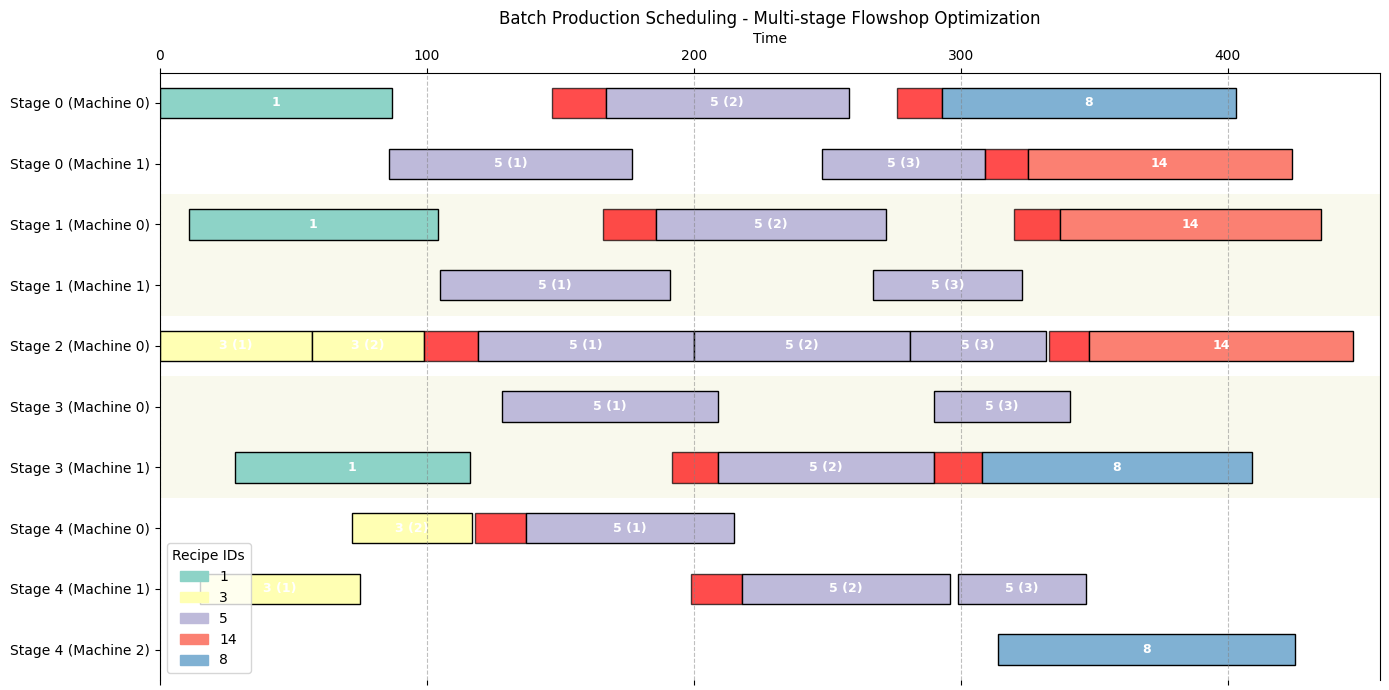

Exported schedule for JS Gantt chart:
{'job_idx': 0, 'stage_idx': 0, 'recipe_id': 1, 'machine': np.int64(0), 'changeover_start': np.float64(0.0), 'changeover_end': np.float64(0.0), 'process_start': np.float64(0.0), 'process_duration': np.float64(87.0), 'process_end': np.float64(87.0)}
{'job_idx': 0, 'stage_idx': 1, 'recipe_id': 1, 'machine': np.int64(0), 'changeover_start': np.float64(0.0), 'changeover_end': np.float64(0.0), 'process_start': np.float64(11.0), 'process_duration': np.float64(93.0), 'process_end': np.float64(104.0)}
{'job_idx': 0, 'stage_idx': 3, 'recipe_id': 1, 'machine': np.int64(1), 'changeover_start': np.float64(0.0), 'changeover_end': np.float64(0.0), 'process_start': np.float64(28.0), 'process_duration': np.float64(88.0), 'process_end': np.float64(116.0)}
{'job_idx': 1, 'stage_idx': 2, 'recipe_id': 3, 'machine': np.int64(0), 'changeover_start': np.float64(0.0), 'changeover_end': np.float64(0.0), 'process_start': np.float64(0.0), 'process_duration': np.float64(57.0),

In [312]:
# Extract and display results
best_x = res.X
best_perm = best_x[:problem.seq_length]
makespan = problem.calculate_makespan(best_x, store_best=True)
problem.best_perm = best_perm

print("====" * 20)
print("Original sequence of recipe IDs:", user_sequence_ids)
print("Best permutation of indices:", best_perm)
print("Best sequence of recipe IDs:", problem.best_sequence_ids)
print("Best machine choices per recipe and stage:\n", problem.best_machine_choices)
print("Best makespan:", problem.max_makespan)

problem.plot_gantt_chart()

schedule_export = problem.export_schedule_for_js()
print("Exported schedule for JS Gantt chart:")
for entry in schedule_export:
    print(entry)